# Introduction to `damage.py` modeule

In [ ]:
import deepimpact
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

outcome = {'burst_altitude': 8e3, 'burst_energy': 7e3,
           'burst_distance': 90e3, 'burst_peak_dedz': 1e3,
           'outcome': 'Airburst'}


This module of the package deepimpact is designed to perform sophisticated calculations related to the assessment of damage and impact risks in a variety of scenarios. It offers a set of tools for determining the geographical point of maximum impact (surface zero) and for calculating the radius of the damage zone

## `damage_zones` function

The `damage_zones` function in the `damage.py` module is a sophisticated tool designed for calculating the impact zone in meteoroid strikes. It essentially serves two purposes: determining the geographic coordinates of surface zero (the point of maximum impact) and calculating the radii of airblast damage zones.

### Functionality

- Surface Zero Calculation: It computes the latitude and longitude of the surface zero point, which is critical for identifying the impact location.

- Damage Zone Radii: The function calculates a series of airblast damage radii, each corresponding to different levels of impact severity. These radii are determined based on varying threshold pressures that signify different damage levels.

Calculating zero_point is as simple as following the formula in the documentation.

Note that the conversion between angle and radian is done during the calculation.

In [ ]:
lat, lon, _ = deepimpact.damage_zones(outcome, 52.79, -2.95, 135, pressures=[1e3, 3.5e3, 27e3, 43e3])

print(lat, lon)


52.21396905216966 -2.015908861677074


I used the function `calculate_surface_zero` to calculate the corresponding latitude and longitude.

We can call this function separately for timing to see the time overhead of the run.

In [ ]:
%%timeit
blat, blon = deepimpact.damage.calculate_surface_zero(52.79, -2.95, 135, outcome['burst_distance'])


7.07 µs ± 75.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


Seems that it's quite fast.

Calculating the blast radius is relatively complex. The blast radius is a non-linear function of pressure, elevation and energy.

Since an analytical solution is not available, we need to approximate it using numerical methods.

A relatively quick way to solve for the approximation is to use the `fsolve` function in `scipy.optimise`. However, we are not allowed to use the existing solver in the assignment.

In [ ]:
# Define the function representing the equation
def equation_to_solve(r, z, k, p):
    return 3 * 10**11 * ((r**2 + z**2) / k**(2/3))**(-1.3) + 2 * 10**7 * ((r**2 + z**2) / k**(2/3))**(-0.57) - p

# Given values
z_value = outcome['burst_altitude']
e_value = outcome['burst_energy']
p_value = 27e3

# Use fsolve to find the root (solution for r)
initial_guess = 1e4
result = fsolve(equation_to_solve, initial_guess, args=(z_value, e_value, p_value))

print("Approximate solution for r:", result[0])


Approximate solution for r: 9518.16176403675


### Mathematical Methods

#### Newton-Raphson Method

The Newton-Raphson method, also known as the Newton method, is a powerful and widely used tool in numerical analysis for finding successively better approximations to the roots (or zeroes) of a real-valued function.

The fundamental idea is to start with an initial guess which is reasonably close to the true root, and then to use the function's derivative to refine that guess iteratively.

The Newton-Raphson formula is:


$$ x_{n+1} = x_n - \frac{f(x_n)}{f'(x_n)} $$

Here, `f(x)` is the function whose root is being sought, and `f'(x)` is its derivative.

The main process of this method is:
- Initial Guess: Begin with a preliminary estimate `x0` of the root.
- Iteration: Use the Newton-Raphson formula to calculate a new approximation `x1`.
- Convergence Check: Assess if the difference between successive approximations is within a desired tolerance level. If not, repeat the iteration process using the new approximation as the starting point.

In [ ]:
def approach_radius_by_newton_raphson(
    p_val, e_val, z_val, r_guess, tolerance=1e-8, max_iter=100
):
    """
    Approach the radius of the meteoroid using Newton-Raphson method

    Parameters
    ----------

    p_val : float
        Pressure value
    e_val : float
        Energy value
    z_val : float
        Altitude value
    r_guess : float
        Initial guess for the radius of the meteoroid
    tolerance : float, optional
        Tolernace of the radius, by default 1e-8
    max_iter : int, optional
        Maximum number of iterations, by default 100

    Returns
    -------

    float
        Radius of the meteoroid

    Acknowledgements
    ----------------

        ChatGPT4
        Github Copilot
    """

    r, z, e, p = sp.symbols("r z e p")

    expression = (
        3 * 10**11 * ((r**2 + z**2) / e ** (2 / 3)) ** (-1.3)
        + 2 * 10**7 * ((r**2 + z**2) / e ** (2 / 3)) ** (-0.57)
        - p
    )

    derivative = sp.diff(expression, r)

    next_iteration = (
        lambda r_value, z_value, e_value, p_value: r_value
        - expression.subs({r: r_value, z: z_value, e: e_value, p: p_value})
        / derivative.subs({r: r_value, z: z_value, e: e_value, p: p_value})
    )

    for i in range(max_iter):
        r_next = next_iteration(r_guess, z_val, e_val, p_val)
        if abs(r_next - r_guess) < tolerance:
            break
        r_guess = r_next

    return float(r_next)


We can use the Newton-Rhapson method to approximate the radius given `P(r)`, `z_b`, `E_k`, which gives a more accurate value. (That's how we've implemented it, too.)

In [ ]:
deepimpact.damage.calculate_damage_radius([27e3, 43e3], outcome['burst_energy'], outcome['burst_altitude'])


[9518.161764036751, 5729.404487549425]

#### Binary Search (binsearch)
Provides the initial guess for the Newton-Raphson method. The binary search algorithm narrows down the range in which the root lies, enhancing the precision of the starting point for Newton-Raphson iterations.

These methods ensure high precision and reliability in calculating the radii for damage assessment in disaster management scenarios.

In [ ]:
def bisect_for_initial_guess(func, interval, tolerance=1e-8, max_iter=100):
    """
    Find the initial guess for the radius of the meteoroid

    Parameters
    ----------

    func : function
        Function to find the initial guess for
    interval : turple
        Interval to find the initial guess in
    tolerance : float, optional
        Tolernace of the initial guess, by default 1e-8
    max_iter : int, optional
        Maximum number of iterations, by default 100

    Returns
    -------

    float
        Initial guess for the radius of the meteoroid
    """

    a, b = interval

    for _ in range(max_iter):
        mid_point = (a + b) / 2
        if func(mid_point) == 0 or (b - a) / 2 < tolerance:
            return mid_point
        elif np.sign(func(mid_point)) == np.sign(func(a)):
            a = mid_point
        else:
            b = mid_point

    return (a + b) / 2


We begin with an approximate solution of the function root using `bisect_for_initial_guess`. During this process, the left and right boundaries are updated until `tolerance` is reached or the maximum number of iterations `max_iter` is reached, by judging the sign of the midpoint of the interval set and the boundaries.

In [6]:
equation_to_solve = lambda r: 3 * 10**11 * ((r**2 + z_value**2) / e_value**(2/3))**(-1.3) + 2 * 10**7 * ((r**2 + z_value**2) / e_value**(2/3))**(-0.57) - p_value
initial_interval = (1e-10, 1e10)

deepimpact.damage.bisect_for_initial_guess(equation_to_solve, initial_interval)


9518.16176404152

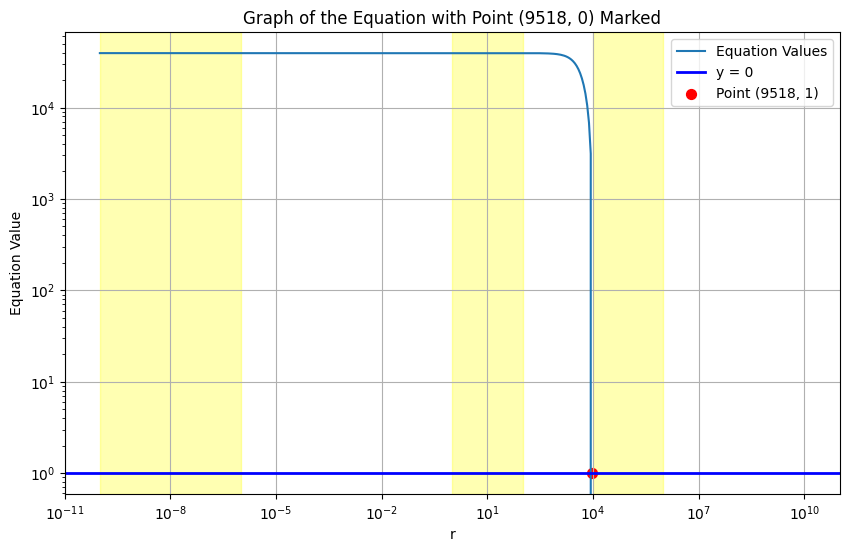

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect

# Define the equation
# z_value = 1.5  # Example value for z_value
# e_value = 2.5  # Example value for e_value
# p_value = 3.0  # Example value for p_value

def equation_to_solve(r):
    return 3 * 10**11 * ((r**2 + z_value**2) / e_value**(2/3))**(-1.3) + 2 * 10**7 * ((r**2 + z_value**2) / e_value**(2/3))**(-0.57) - p_value

# Define the range of r values
r_values = np.logspace(-10, 10, 400)

# Calculate the corresponding values of the equation
equation_values = [equation_to_solve(r) for r in r_values]

# Adjusted intervals for root finding
adjusted_intervals = [(1e-10, 1e-6), (1e0, 1e2), (1e4, 1e6)]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.loglog(r_values, equation_values, label="Equation Values")
plt.axhline(1, color='blue', lw=2, label="y = 0")

# Highlighting the adjusted intervals
for interval in adjusted_intervals:
    plt.axvspan(interval[0], interval[1], color='yellow', alpha=0.3)

# Marking the point (9518, 0)
plt.scatter(9518.16176404152, 1, color='red', s=50, label="Point (9518, 1)")

plt.xlabel("r")
plt.ylabel("Equation Value")
plt.title("Graph of the Equation with Point (9518, 0) Marked")
plt.legend()
plt.grid(True)
plt.show()


Thereafter, we use the approximate root as the initial value of `r_guess`, perform an exact approximation using Newton's method, and save the final result. Then we can call these helper functions in damage_zones to get our desired outputs.

In [8]:
_, __, radii = deepimpact.damage_zones(outcome, 52.79, -2.95, 135, pressures=[1e3, 3.5e3, 27e3, 43e3])

print(radii)


[117474.67966268047, 43146.33898840085, 9518.161764036751, 5729.404487549425]


Let's take a look at the time it will take to complete the calculation.

In [9]:
%%timeit
_, __, radii = deepimpact.damage_zones(outcome, 52.79, -2.95, 135, pressures=[1e3, 3.5e3, 27e3, 43e3])


1.53 ms ± 3.39 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


That's good! Time consumption for small samples was kept to milliseconds.

## Description of the Impact Risk function

# Impact Risk Function Description

The `impact_risk` function is designed to evaluate the risk associated with various impact scenarios, specifically targeting geographical areas delineated by postcodes. It serves a critical role in risk assessment and disaster preparedness by providing insights into the potential effects of catastrophic events. The function operates by analyzing a comprehensive dataset of impact scenarios, each characterized by a unique set of parameters.

## Functionality

- **Input**: The function takes a `.csv` file as input. This file comprises a distribution of hypothetical impact scenarios. Each scenario includes detailed attributes such as radius, angle, velocity, density, strength, entry latitude, entry longitude, and bearing.

- **Output**: The function outputs two key pieces of information:
  1. **Postcode Risk Probability**: It calculates the fractional probability that each postcode falls within a specified damage level for each scenario. This probability is determined by the ratio of the number of times a postcode is within the damage level to the total number of scenarios.
  2. **Population Impact Statistics**: It provides statistical data — mean and standard deviation — regarding the total population affected by the impacts. The 'affected population' is defined as those residing within the blast radius of a specified damage level, measured by a user-defined pressure threshold (e.g., 30 kPa).

## Key Features

- **Risk Assessment by Postcode**: By focusing on postcodes, the function offers granular insights into the risk distribution across different areas, essential for localized disaster management strategies.

- **Statistical Analysis of Population Impact**: The function's capability to compute the mean and standard deviation of the affected population under different scenarios aids in understanding the potential scale and variability of impact, facilitating better resource allocation and emergency planning.

## Use Case

The `impact_risk` function is particularly valuable for governmental agencies, emergency response teams, and urban planners in preparing for and mitigating the effects of catastrophic events. Its data-driven approach provides a scientific basis for risk mitigation strategies, emergency response planning, and resource allocation.

In summary, the `impact_risk` function is a powerful tool for assessing the risks associated with various impact scenarios, providing vital data for effective disaster management and preparedness.


In [10]:
planet = deepimpact.Planet()


In [12]:
df, pop_stats = deepimpact.impact_risk(planet)


In [13]:
df


,postcode,probability
0,CV130AA,0.4
1,CV130AB,0.4
2,CV130AD,0.4
3,CV130AE,0.7
4,CV130AG,0.6
...,...,...
13628,LE9 6TP,0.2
13629,LE9 6TQ,0.2
13630,LE9 6TS,0.1
13631,LE9 6TX,0.2


In [14]:
pop_stats


{'mean': 214391.9, 'stdev': 131203.22354687023}